In [1]:
# matching cmes to seps 
# use SEP onset time as reference and find cme donki time which should precede SEP onset time within time widow
# when match is found, calculate time difference, CME time - SEP onset time. SEP onset time -> CME time (those are real solar events that happened that i am trying to find)
# If SEP doesn't have a CME match, look further back in time to 6 hours earlier, and potentially keep looking back
# within the time widow, we are finding other CMEs that happened within the time widow. Meaning SEPs may have multiple CME candidate sources. Find all the matching CMEs if there are more than one.
# calculate time difference for all matched CMEs, time_diff = CME_time - SEP_onset_time
# since CME precede SEPs, the difference is negative. In case of multiple CME matches, take the largest (smallest negative value) time difference as
# the precursor CME for that SEP. 
# make it dynamic so the SEP time to match can be changed to peak time or else and the time to look back for matching is variable
# in DONKI cme dataset, take the DONKI date (as donki time), and in pf10th10 dataset, take the onset time. first row (index 0) in group of 4 rows.
# record the intensities of the SEPs.

# results table has rows as CMEs
# for matching, it can be match for one matching CME, or matching multiple SEPs then dup or matching none then blank.
# duplicates because of multiple SEPs that match a single CME
# additional inputs consist of the years to pay attention to: 2010 to 2017

In [2]:
# we are going to read these two files and build a dataset by matching events in these datasets. let's call  DONKI_CDAW_CMEs_original.csv as dataset A and curr_pf10th10_original.csv as dataset B. from data set A, we are interested in donki_date, latitude, longitude, donki_speed  columns for every row. For dataset B, we are interested in  datetime, intensity columns for each group of 4 rows (index with the Index column 1 to 4). We will be using datetime index 1 (first row) of a group of 4 rows to match with donki_date 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union, Optional
from collections import defaultdict

In [2]:
# Read dataset A
dataset_a_path = '../cme_and_electron/DONKI_CDAW_CMEs_original.csv'
dataset_a = pd.read_csv(dataset_a_path)

# Read dataset B
dataset_b_path = '../cme_and_electron/curr_pf10th10_original.csv'
dataset_b = pd.read_csv(dataset_b_path)

# Show the first few rows of each dataset to understand their structure
dataset_a.head(), dataset_b.head()


(            donki_date            cdaw_date  ESP  2nd_order_speed_20R  \
 0  2010-04-03 09:54:00  2010-04-03 10:33:00    0                  661   
 1  2010-06-13 07:32:00  2010-06-13 06:30:00    0                  435   
 2  2010-06-20 03:18:00  2010-06-20 02:06:00    0                  548   
 3  2010-07-03 01:30:00  2010-07-03 01:30:00    0                  447   
 4  2010-08-01 02:42:00  2010-08-01 00:30:00    0                    0   
 
    latitude  longitude  donki_ha  donki_speed  solar_wind_speed  Type_2_Area  \
 0         7        8.0        26          620             487.3            0   
 1        17      117.0        30          500             427.5            0   
 2       -13      -80.0        20          570             387.2            0   
 3        -4       35.0        23          625             602.6            0   
 4         7      -22.0        48          760             509.8            0   
 
    ...  Max_speed_past_day  CMEs_over_1000_past_9_hrs  sunspots  

In [3]:
# Convert 'donki_date' and 'datetime' columns to datetime objects for better manipulation
dataset_a['donki_date'] = pd.to_datetime(dataset_a['donki_date'])
dataset_b['datetime'] = pd.to_datetime(dataset_b['datetime'])

In [4]:
# Initialize parameters
initial_time_window = 180  # 3 hours in minutes
window_limit = 1000 * 60  # 24 hours in minutes
lower_year = 2010  # inclusive
upper_year = 2017  # inclusive
index_to_match = 1  # index of SEP onset row

In [5]:
def filter_columns_from_dataset_a(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out the required columns from dataset A.
    
    Parameters:
        df (pd.DataFrame): The original dataset A DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame containing only the required columns.
    """
    return df[['donki_date', 'latitude', 'longitude', 'donki_speed']]


def filter_and_aggregate_dataset_b(df: pd.DataFrame, index_param: int = 1) -> pd.DataFrame:
    """
    Filters out the required columns from dataset B and aggregates rows based on the index parameter.
    
    Parameters:
        df (pd.DataFrame): The original dataset B DataFrame.
        index_param (int): The index parameter to group rows.
    
    Returns:
        pd.DataFrame: DataFrame containing aggregated rows and the required columns.
    """
    # Filter columns
    filtered_df = df[df['Index'] == index_param][['datetime', 'Intensity']]

    return filtered_df

In [6]:
# Filter columns from dataset A
filtered_dataset_a = filter_columns_from_dataset_a(dataset_a)

# Filter and aggregate dataset B with the default index parameter of 1
filtered_dataset_b = filter_and_aggregate_dataset_b(dataset_b, index_to_match)

In [7]:
# Show the first few rows of the filtered DataFrames
filtered_dataset_a.head(n=100)

,donki_date,latitude,longitude,donki_speed
0,2010-04-03 09:54:00,7,8.0,620
1,2010-06-13 07:32:00,17,117.0,500
2,2010-06-20 03:18:00,-13,-80.0,570
3,2010-07-03 01:30:00,-4,35.0,625
4,2010-08-01 02:42:00,7,-22.0,760
...,...,...,...,...
95,2011-06-23 12:39:00,2,-40.0,350
96,2011-06-29 01:25:00,-20,60.0,490
97,2011-07-09 00:54:00,-25,-30.0,850
98,2011-07-09 17:42:00,20,112.0,838


In [8]:
filtered_dataset_b.head(n=100)

,datetime,Intensity
0,1995-10-20 06:20:00,0.111190
4,1997-11-04 06:04:00,0.169200
8,1997-11-06 12:24:00,1.751300
12,1998-04-20 11:10:00,0.195370
16,1998-05-02 13:50:00,0.177920
...,...,...
380,2004-09-13 19:54:00,0.428170
384,2004-09-19 17:35:00,0.094505
388,2004-11-01 05:55:00,0.188800
392,2004-11-07 17:44:00,0.758930


In [9]:
def populate_intensity_values(sep_datetime: str, unfiltered_seps: pd.DataFrame, index_to_match: int = 1) -> Tuple[
    float, float, float, float]:
    """
    Populate the intensity values of "onset", "threshold", "peak", and "ending" for a given SEP event.
    
    Parameters:
        sep_datetime (str): The datetime of the SEP onset.
        unfiltered_seps (pd.DataFrame): The dataset containing SEP events.
        index_to_match (int): The index of the SEP onset row for which to find the other intensity values.
        
    Returns:
        Tuple[float, float, float, float]: The intensities of "onset", "threshold", "peak", and "ending".
    """

    print(f'Sep datetime {sep_datetime} index_to_match: {index_to_match}')
    # print(unfiltered_seps)
    print(unfiltered_seps['datetime'])

    # Find the SEP event that matches the given datetime and index
    matching_sep = unfiltered_seps[
        (unfiltered_seps['datetime'] == sep_datetime) & (unfiltered_seps['Index'] == index_to_match)]

    if matching_sep.empty:
        print(f'No matching SEP event found for {sep_datetime}')
        return np.nan, np.nan, np.nan, np.nan
    else:
        print(f'Matching SEP event found for {sep_datetime}')
    # Find the index of the onset row for the matched SEP event
    onset_idx = matching_sep.index[0]

    # Fetch the intensities for "onset", "threshold", "peak", and "ending" stages
    try:
        onset = unfiltered_seps.loc[onset_idx, 'Intensity']
        threshold = unfiltered_seps.loc[onset_idx + 1, 'Intensity']
        peak = unfiltered_seps.loc[onset_idx + 2, 'Intensity']
        ending = unfiltered_seps.loc[onset_idx + 3, 'Intensity']
    except KeyError:
        # Return NaNs if any of the required rows are missing
        return np.nan, np.nan, np.nan, np.nan

    return onset, threshold, peak, ending


In [10]:

def find_matching_seps(cme_row: pd.Series, seps: pd.DataFrame,
                       initial_time_window: int = 180, window_limit: int = 1440) -> Tuple[
    List[pd.Series], List[int]]:
    """
    Finds matching SEPs for a given CME row within a specified initial time window and expands it if no matches are found.
    
    Parameters:
        cme_row (pd.Series): A row from dataset A representing a CME event.
        seps (pd.DataFrame): Filtered dataset B containing SEP events.
        initial_time_window (int): Initial time window in minutes for matching CMEs to SEPs.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[List[pd.Series], List[int]]: The list of matching SEP rows and their time differences in minutes.
    """
    time_window = initial_time_window
    matching_seps = []
    matching_time_diffs = []

    while time_window <= window_limit:
        time_diffs = (cme_row['donki_date'] - seps['datetime']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(-time_window, 0)  # Only consider negative time differences (CME before SEP)
        matching_seps = seps[within_window]

        if not matching_seps.empty:
            matching_time_diffs = time_diffs[within_window].tolist()
            break

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return matching_seps, matching_time_diffs

In [11]:
def find_closest_matching_seps(cme_row: pd.Series, seps: pd.DataFrame,
                               initial_time_window: int = 180,
                               window_limit: int = 1440) -> Tuple[pd.Series, int]:
    """
    Finds the closest matching SEP for a given CME row within a specified initial time window and expands it if no matches are found.
    Tracks already matched SEPs to avoid multiple CMEs matching to a single SEP.
    
    Parameters:
        cme_row (pd.Series): A row from dataset A representing a CME event.
        seps (pd.DataFrame): Filtered dataset B containing SEP events.
        initial_time_window (int): Initial time window in minutes for matching CMEs to SEPs.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[pd.Series, int]: The closest matching SEP row and its time difference in minutes.
    """
    time_window = initial_time_window
    closest_match = None
    closest_time_diff = float('inf')

    while time_window <= window_limit:
        time_diffs = (cme_row['donki_date'] - seps['datetime']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(-time_window, 0)  # Only consider negative time differences (CME before SEP)
        matching_seps = seps[within_window]
        matching_time_diffs = time_diffs[within_window]

        if not matching_seps.empty:
            min_time_diff_idx = matching_time_diffs.idxmin()
            if matching_time_diffs[min_time_diff_idx] < closest_time_diff:
                closest_time_diff = matching_time_diffs[min_time_diff_idx]
                closest_match = matching_seps.loc[min_time_diff_idx]

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return closest_match, closest_time_diff

In [12]:
columns_for_matches = ['CME_speed', 'CME_latitude', 'CME_longitude', 'CME_time', 'SEP_onset_time', 'time_difference',
                       'matching', 'SEP_onset_intensity', 'SEP_threshold_intensity', 'SEP_peak_intensity',
                       'SEP_ending_intensity']

# Create explicit copies after filtering based on years
filtered_dataset_a = filtered_dataset_a.copy()
filtered_dataset_b = filtered_dataset_b.copy()

# Explicitly convert 'donki_date' and 'datetime' to datetime objects again after filtering
filtered_dataset_a['donki_date'] = pd.to_datetime(filtered_dataset_a['donki_date'])
filtered_dataset_b['datetime'] = pd.to_datetime(filtered_dataset_b['datetime'])

# Show data types of 'donki_date' in dataset A and 'datetime' in dataset B
print("Data type of 'donki_date' in dataset A:", filtered_dataset_a['donki_date'].dtype)
print("Data type of 'datetime' in dataset B:", filtered_dataset_b['datetime'].dtype)

# Add the 'year' column again
filtered_dataset_a['year'] = filtered_dataset_a['donki_date'].dt.year
filtered_dataset_b['year'] = filtered_dataset_b['datetime'].dt.year

# Filter datasets based on year constraints
filtered_dataset_a = filtered_dataset_a[
    (filtered_dataset_a['year'] >= lower_year) & (filtered_dataset_a['year'] <= upper_year)]
filtered_dataset_b = filtered_dataset_b[
    (filtered_dataset_b['year'] >= lower_year) & (filtered_dataset_b['year'] <= upper_year)]


Data type of 'donki_date' in dataset A: datetime64[ns]
Data type of 'datetime' in dataset B: datetime64[ns]


In [13]:
# print filtered_dataset_a
filtered_dataset_a.head(n=100)

,donki_date,latitude,longitude,donki_speed,year
0,2010-04-03 09:54:00,7,8.0,620,2010
1,2010-06-13 07:32:00,17,117.0,500,2010
2,2010-06-20 03:18:00,-13,-80.0,570,2010
3,2010-07-03 01:30:00,-4,35.0,625,2010
4,2010-08-01 02:42:00,7,-22.0,760,2010
...,...,...,...,...,...
95,2011-06-23 12:39:00,2,-40.0,350,2011
96,2011-06-29 01:25:00,-20,60.0,490,2011
97,2011-07-09 00:54:00,-25,-30.0,850,2011
98,2011-07-09 17:42:00,20,112.0,838,2011


In [14]:
# print filtered_dataset_b
filtered_dataset_b.head(n=100)


,datetime,Intensity,year
448,2010-08-14 10:25:00,0.123710,2010
452,2011-03-07 21:40:00,0.154310,2011
456,2011-03-21 06:24:00,2.721500,2011
460,2011-06-07 06:54:00,2.196500,2011
464,2011-08-04 03:45:00,0.198140,2011
468,2011-08-09 08:10:00,0.351730,2011
472,2011-09-23 15:00:00,4.978700,2011
476,2011-10-22 12:49:00,0.135930,2011
480,2011-11-26 08:05:00,0.139810,2011
484,2012-01-23 04:39:00,1.471200,2012


In [15]:
# Reinitialize an empty DataFrame for storing matches
matches_CME_SEPs = pd.DataFrame(columns=columns_for_matches)
# empty list of new rows
new_rows = []

In [16]:
# Loop through each row in dataset A to find matching SEPs from dataset B
for idx, cme_row in filtered_dataset_a.iterrows():
    matching_seps, matching_time_diffs = find_matching_seps(
        cme_row, filtered_dataset_b, initial_time_window, window_limit)

    # Prepare data for new row in matches_CME_SEPs
    new_row = {
        'CME_speed': cme_row['donki_speed'],
        'CME_latitude': cme_row['latitude'],
        'CME_longitude': cme_row['longitude'],
        'CME_time': cme_row['donki_date'],
        'SEP_onset_time': np.nan,
        'time_difference': np.nan,
        'matching': '',
        'SEP_onset_intensity': np.nan,
        'SEP_threshold_intensity': np.nan,
        'SEP_peak_intensity': np.nan,
        'SEP_ending_intensity': np.nan
    }

    if len(matching_seps) > 0:
        # Populate fields if matches are found
        if len(matching_seps) > 1:
            new_row['matching'] = 'dup'
        else:
            new_row['matching'] = 'match'

        # Use the closest match for other fields
        closest_match = matching_seps.iloc[0]
        closest_match_time_diff = matching_time_diffs[0]

        # print("Data type of 'datetime' in closest_match:", type(closest_match['datetime']))

        new_row.update({
            'SEP_onset_time': closest_match['datetime'],
            'time_difference': closest_match_time_diff
        })

        print('Data type of dataset_b in new_row:', dataset_b['datetime'].dtype)

        # Find the intensities at indices 1-4 for the matched SEP
        onset, threshold, peak, ending = populate_intensity_values(closest_match['datetime'], dataset_b, index_to_match)
        new_row.update({
            'SEP_onset_intensity': onset,
            'SEP_threshold_intensity': threshold,
            'SEP_peak_intensity': peak,
            'SEP_ending_intensity': ending
        })

    # Add the new row to the list
    new_rows.append(new_row)

# Use pd.concat to add all new rows to matches_CME_SEPs
matches_CME_SEPs = pd.DataFrame(new_rows, columns=columns_for_matches)

Data type of dataset_b in new_row: datetime64[ns]
Sep datetime 2010-08-14 10:25:00 index_to_match: 1
0     1995-10-20 06:20:00
1     1995-10-20 08:15:00
2     1995-10-20 12:15:00
3     1995-10-21 02:30:00
4     1997-11-04 06:04:00
              ...        
627   2017-09-09 02:44:00
628   2017-09-10 15:35:00
629   2017-09-10 16:50:00
630   2017-09-11 11:50:00
631   2017-09-14 20:05:00
Name: datetime, Length: 632, dtype: datetime64[ns]
Matching SEP event found for 2010-08-14 10:25:00
Data type of dataset_b in new_row: datetime64[ns]
Sep datetime 2011-03-07 21:40:00 index_to_match: 1
0     1995-10-20 06:20:00
1     1995-10-20 08:15:00
2     1995-10-20 12:15:00
3     1995-10-21 02:30:00
4     1997-11-04 06:04:00
              ...        
627   2017-09-09 02:44:00
628   2017-09-10 15:35:00
629   2017-09-10 16:50:00
630   2017-09-11 11:50:00
631   2017-09-14 20:05:00
Name: datetime, Length: 632, dtype: datetime64[ns]
Matching SEP event found for 2011-03-07 21:40:00
Data type of dataset_b in 

KeyboardInterrupt: 

In [18]:
# Show the first few rows of the matches_CME_SEPs DataFrame
matches_CME_SEPs.head(100)


,CME_speed,CME_latitude,CME_longitude,CME_time,SEP_onset_time,time_difference,matching,SEP_onset_intensity,SEP_threshold_intensity,SEP_peak_intensity,SEP_ending_intensity
0,620,7,8.0,2010-04-03 09:54:00,NaT,NaN,,NaN,NaN,NaN,NaN
1,500,17,117.0,2010-06-13 07:32:00,NaT,NaN,,NaN,NaN,NaN,NaN
2,570,-13,-80.0,2010-06-20 03:18:00,NaT,NaN,,NaN,NaN,NaN,NaN
3,625,-4,35.0,2010-07-03 01:30:00,NaT,NaN,,NaN,NaN,NaN,NaN
4,760,7,-22.0,2010-08-01 02:42:00,NaT,NaN,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,350,2,-40.0,2011-06-23 12:39:00,NaT,NaN,,NaN,NaN,NaN,NaN
96,490,-20,60.0,2011-06-29 01:25:00,NaT,NaN,,NaN,NaN,NaN,NaN
97,850,-25,-30.0,2011-07-09 00:54:00,NaT,NaN,,NaN,NaN,NaN,NaN
98,838,20,112.0,2011-07-09 17:42:00,NaT,NaN,,NaN,NaN,NaN,NaN


In [19]:
# Save the matches_CME_SEPs DataFrame to a CSV file
csv_file_path = '../cme_and_electron/matches_CME_SEPs.csv'
matches_CME_SEPs.to_csv(csv_file_path, index=False)

# to get the exact amount of SEPs , i will have to go by SEPs to CMEs

In [16]:
def find_closest_cme(sep_row: pd.Series, cmes: pd.DataFrame,
                     initial_time_window: int = 180, window_limit: int = 1440) -> Tuple[
    Union[pd.Series, None], Union[float, None]]:
    """
    Finds the closest matching CME for a given SEP row within a specified initial time window and expands it if no matches are found.
    
    Parameters:
        sep_row (pd.Series): A row from dataset B representing an SEP event.
        cmes (pd.DataFrame): Filtered dataset A containing CME events.
        initial_time_window (int): Initial time window in minutes for matching SEP to CME.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[Union[pd.Series, None], Union[float, None]]: The closest matching CME row and the time difference in minutes.
    """
    time_window = initial_time_window
    closest_cme = None
    closest_time_diff = None

    while time_window <= window_limit:
        time_diffs = (sep_row['datetime'] - cmes['donki_date']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(0, time_window)  # Only consider positive time differences (SEP after CME)

        if within_window.sum() > 0:
            # Find the closest match within the time window
            closest_cme_idx = time_diffs[within_window].idxmin()
            closest_cme = cmes.loc[closest_cme_idx]
            closest_time_diff = time_diffs[closest_cme_idx]
            break

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return closest_cme, closest_time_diff

In [17]:
# Step 1: Pre-populate target table with all CMEs
new_rows = []
for idx, cme_row in filtered_dataset_a.iterrows():
    new_row = {
        'CME_speed': cme_row['donki_speed'],
        'CME_latitude': cme_row['latitude'],
        'CME_longitude': cme_row['longitude'],
        'CME_time': cme_row['donki_date'],
        'SEP_onset_time': np.nan,
        'time_difference': np.nan,
        'matching': '',
        'SEP_onset_intensity': np.nan,
        'SEP_threshold_intensity': np.nan,
        'SEP_peak_intensity': np.nan,
        'SEP_ending_intensity': np.nan
    }
    new_rows.append(new_row)

matches_CME_SEPs = pd.DataFrame(new_rows, columns=columns_for_matches)

# Step 2 & 3: Find closest matching CME for each SEP and update the target table
closest_cmes_for_seps = {}  # To keep track of closest CMEs for each SEP

for idx, sep_row in filtered_dataset_b.iterrows():
    closest_cme, closest_time_diff = find_closest_cme(sep_row, filtered_dataset_a, initial_time_window, window_limit)
    sep_id = sep_row['datetime']

    print(f'Closest time difference for SEP {sep_id} is {closest_time_diff}')

    if closest_cme is not None:
        cme_id = closest_cme['donki_date']
        # Check if this CME is already the closest match for another SEP
        if cme_id in closest_cmes_for_seps:
            closest_cmes_for_seps[cme_id]['matching'] = 'dup'
            closest_cmes_for_seps[cme_id]['SEPs'].append({'sep': sep_row, 'time_diff': closest_time_diff})
        else:
            closest_cmes_for_seps[cme_id] = {'matching': 'match',
                                             'SEPs': [{'sep': sep_row, 'time_diff': closest_time_diff}]}

new_rows = []

for cme_id, cme_info in closest_cmes_for_seps.items():
    # Get CME details from the original DataFrame
    cme_details = matches_CME_SEPs.loc[matches_CME_SEPs['CME_time'] == cme_id].iloc[0]

    # Loop through all SEPs that have this CME as the closest match
    for sep_info in cme_info['SEPs']:
        closest_sep = sep_info['sep']
        closest_time_diff = sep_info['time_diff']

        onset, threshold, peak, ending = populate_intensity_values(closest_sep['datetime'], dataset_b, index_to_match)

        updated_values = {
            'SEP_onset_time': closest_sep['datetime'],
            'time_difference': -closest_time_diff,
            'matching': cme_info['matching'],
            'SEP_onset_intensity': onset,
            'SEP_threshold_intensity': threshold,
            'SEP_peak_intensity': peak,
            'SEP_ending_intensity': ending
        }

        if cme_info['matching'] == 'dup':
            # Create a new row with CME details and new SEP details
            new_row = cme_details.copy()
            new_row.update(updated_values)
            new_rows.append(new_row)
        else:
            # Update the existing row in the DataFrame
            matches_CME_SEPs.loc[matches_CME_SEPs['CME_time'] == cme_id, updated_values.keys()] = list(
                updated_values.values())

# Convert the list of new rows to a DataFrame and concatenate it with the original DataFrame
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    matches_CME_SEPs = pd.concat([matches_CME_SEPs, new_rows_df], ignore_index=True)


Closest time difference for SEP 2010-08-14 10:25:00 is 13.0
Closest time difference for SEP 2011-03-07 21:40:00 is 88.0
Closest time difference for SEP 2011-03-21 06:24:00 is 210.0
Closest time difference for SEP 2011-06-07 06:54:00 is 4.0
Closest time difference for SEP 2011-08-04 03:45:00 is 830.0
Closest time difference for SEP 2011-08-09 08:10:00 is 850.0
Closest time difference for SEP 2011-09-23 15:00:00 is 1656.0
Closest time difference for SEP 2011-10-22 12:49:00 is 89.0
Closest time difference for SEP 2011-11-26 08:05:00 is 53.0
Closest time difference for SEP 2012-01-23 04:39:00 is 39.0
Closest time difference for SEP 2012-01-27 18:29:00 is 110.0
Closest time difference for SEP 2012-03-07 02:50:00 is 134.0
Closest time difference for SEP 2012-03-07 22:30:00 is 1314.0
Closest time difference for SEP 2012-03-13 17:44:00 is 9668.0
Closest time difference for SEP 2012-05-17 01:25:00 is 1366.0
Closest time difference for SEP 2012-05-26 22:59:00 is 5.0
Closest time difference for S

In [18]:
matches_CME_SEPs.head(n=100)

,CME_speed,CME_latitude,CME_longitude,CME_time,SEP_onset_time,time_difference,matching,SEP_onset_intensity,SEP_threshold_intensity,SEP_peak_intensity,SEP_ending_intensity
0,620,7,8.0,2010-04-03 09:54:00,NaN,NaN,,NaN,NaN,NaN,NaN
1,500,17,117.0,2010-06-13 07:32:00,NaN,NaN,,NaN,NaN,NaN,NaN
2,570,-13,-80.0,2010-06-20 03:18:00,NaN,NaN,,NaN,NaN,NaN,NaN
3,625,-4,35.0,2010-07-03 01:30:00,NaN,NaN,,NaN,NaN,NaN,NaN
4,760,7,-22.0,2010-08-01 02:42:00,NaN,NaN,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,350,2,-40.0,2011-06-23 12:39:00,NaN,NaN,,NaN,NaN,NaN,NaN
96,490,-20,60.0,2011-06-29 01:25:00,NaN,NaN,,NaN,NaN,NaN,NaN
97,850,-25,-30.0,2011-07-09 00:54:00,NaN,NaN,,NaN,NaN,NaN,NaN
98,838,20,112.0,2011-07-09 17:42:00,NaN,NaN,,NaN,NaN,NaN,NaN


# Finding Elevated Events

In [2]:
# Read dataset A
dataset_a_path = '../cme_and_electron/matches_CME_SEPs - curated - updated.csv'
dataset_a = pd.read_csv(dataset_a_path)

# Read dataset B
dataset_b_path = '../cme_and_electron/curr_pf10th10re2.csv'
dataset_b = pd.read_csv(dataset_b_path)

# Show the first few rows of each dataset to understand their structure
dataset_a.head(), dataset_b.head()

(   CME_speed  CME_latitude  CME_longitude        CME_time SEP_onset_time  \
 0        620             7            8.0   4/3/2010 9:54            NaN   
 1        500            17          117.0  6/13/2010 7:32            NaN   
 2        570           -13          -80.0  6/20/2010 3:18            NaN   
 3        625            -4           35.0   7/3/2010 1:30            NaN   
 4        760             7          -22.0   8/1/2010 2:42            NaN   
 
    time_difference matching  SEP_peak_intensity Unnamed: 8  
 0              NaN      NaN                 NaN        NaN  
 1              NaN      NaN                 NaN        NaN  
 2              NaN      NaN                 NaN        NaN  
 3              NaN      NaN                 NaN        NaN  
 4              NaN      NaN                 NaN        NaN  ,
    Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
 0           0  2.450011e+06  1995  293.26389    0.11119      0.000      1   
 1     

In [3]:
# Convert 'donki_date' and 'datetime' columns to datetime objects for better manipulation
dataset_a['CME_time'] = pd.to_datetime(dataset_a['CME_time'])
dataset_b['datetime'] = pd.to_datetime(dataset_b['datetime'])

In [4]:
# Initialize parameters
initial_time_window = 180  # 3 hours in minutes
window_limit = 1000 * 60  # 24 hours in minutes
lower_year = 2010  # inclusive
upper_year = 2017  # inclusive
index_to_match = 1  # index of Elevated onset row

In [5]:
def filter_columns_from_dataset_a(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out the required columns from dataset A.
    
    Parameters:
        df (pd.DataFrame): The original dataset A DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame containing only the required columns.
    """
    return df[['CME_speed', 'CME_latitude', 'CME_longitude', 'CME_time']]


def filter_and_aggregate_dataset_b(df: pd.DataFrame, index_param: int = 1) -> pd.DataFrame:
    """
    Filters out the required columns from dataset B and aggregates rows based on the index parameter.
    Additionally, removes the group of SEPs where the 'Intensity' at 'Index' 3 is greater than or equal to 10.
    
    Parameters:
        df (pd.DataFrame): The original dataset B DataFrame.
        index_param (int): The index parameter to filter rows for onset time.
    
    Returns:
        pd.DataFrame: DataFrame containing aggregated rows and the required columns after filtering.
    """
    # Step 1: Identify groups where 'Intensity' at 'Index' 3 is >= 10
    # Since they come in groups of 4, we will check every 4th element starting from the 3rd index (0-based)
    groups_to_remove = []
    for i in range(2, len(df), 4):
        if df.loc[i, 'Intensity'] >= 10:
            groups_to_remove.extend(range(i - 2, i + 2))

    # Remove identified groups
    filtered_df = df.drop(groups_to_remove, errors='ignore')

    # Step 2: Filter by 'Index' and taking only 'datetime' and 'Intensity' columns
    filtered_df = filtered_df[filtered_df['Index'] == index_param][['datetime', 'Intensity']]

    return filtered_df


In [6]:
# Filter columns from dataset A
filtered_dataset_a = filter_columns_from_dataset_a(dataset_a)

# Filter and aggregate dataset B with the default index parameter of 1
filtered_dataset_b = filter_and_aggregate_dataset_b(dataset_b, index_to_match)

In [7]:
# Show the first few rows of the filtered DataFrames
filtered_dataset_a.head(n=100)

,CME_speed,CME_latitude,CME_longitude,CME_time
0,620,7,8.0,2010-04-03 09:54:00
1,500,17,117.0,2010-06-13 07:32:00
2,570,-13,-80.0,2010-06-20 03:18:00
3,625,-4,35.0,2010-07-03 01:30:00
4,760,7,-22.0,2010-08-01 02:42:00
...,...,...,...,...
95,350,2,-40.0,2011-06-23 12:39:00
96,490,-20,60.0,2011-06-29 01:25:00
97,850,-25,-30.0,2011-07-09 00:54:00
98,838,20,112.0,2011-07-09 17:42:00


In [8]:
filtered_dataset_b.head(n=100)

,datetime,Intensity
8,1997-11-13 23:30:00,0.28051
16,1998-04-29 18:04:00,0.16804
20,1998-05-01 03:49:00,0.67055
36,1998-06-16 21:15:00,0.12050
40,1998-08-22 16:09:00,0.35469
...,...,...
824,2013-11-19 12:04:00,0.12475
828,2013-12-14 14:44:00,0.40125
832,2013-12-26 15:35:00,0.32855
848,2014-02-19 04:00:00,0.14628


In [9]:
def populate_peak_intensity(sep_datetime: str, unfiltered_seps: pd.DataFrame, index_to_match: int = 1) -> float:
    """
    Populate the intensity values of "onset", "threshold", "peak", and "ending" for a given SEP event.
    
    Parameters:
        sep_datetime (str): The datetime of the SEP onset.
        unfiltered_seps (pd.DataFrame): The dataset containing SEP events.
        index_to_match (int): The index of the SEP onset row for which to find the other intensity values.
        
    Returns:
       float: The intensity of "peak"
    """

    print(f'Elevated datetime {sep_datetime} index_to_match: {index_to_match}')
    # print(unfiltered_seps)
    print(unfiltered_seps['datetime'])

    # Find the SEP event that matches the given datetime and index
    matching_sep = unfiltered_seps[
        (unfiltered_seps['datetime'] == sep_datetime) & (unfiltered_seps['Index'] == index_to_match)]

    if matching_sep.empty:
        print(f'No matching SEP event found for {sep_datetime}')
        return np.nan
    else:
        print(f'Matching SEP event found for {sep_datetime}')
    # Find the index of the onset row for the matched SEP event
    onset_idx = matching_sep.index[0]

    # Fetch the intensities for "onset", "threshold", "peak", and "ending" stages
    try:
        # onset = unfiltered_seps.loc[onset_idx, 'Intensity']
        # threshold = unfiltered_seps.loc[onset_idx + 1, 'Intensity']
        peak = unfiltered_seps.loc[onset_idx + 2, 'Intensity']
        # ending = unfiltered_seps.loc[onset_idx + 3, 'Intensity']
    except KeyError:
        # Return NaNs if any of the required rows are missing
        return np.nan

    return peak

In [10]:
def find_matching_seps(cme_row: pd.Series, seps: pd.DataFrame,
                       initial_time_window: int = 180, window_limit: int = 1440) -> Tuple[List[pd.Series], List[int]]:
    """
    Finds matching SEPs for a given CME row within a specified initial time window and expands it if no matches are found.
    
    Parameters:
        cme_row (pd.Series): A row from dataset A representing a CME event.
        seps (pd.DataFrame): Filtered dataset B containing SEP events.
        initial_time_window (int): Initial time window in minutes for matching CMEs to SEPs.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[List[pd.Series], List[int]]: The list of matching SEP rows and their time differences in minutes.
    """
    time_window = initial_time_window
    matching_seps = pd.DataFrame()
    matching_time_diffs = []

    while time_window <= window_limit:
        time_diffs = (cme_row['donki_date'] - seps['datetime']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(-time_window, 0)  # Only consider negative time differences (CME before SEP)

        # Get the SEPs within the time window
        potential_matches = seps[within_window]

        # Filter out SEPs with peak intensity >= 10
        matching_seps = potential_matches[potential_matches['Intensity'] < 10]

        if not matching_seps.empty:
            matching_time_diffs = time_diffs[within_window].tolist()
            break

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return matching_seps, matching_time_diffs

In [11]:
def find_closest_matching_seps(cme_row: pd.Series, seps: pd.DataFrame,
                               initial_time_window: int = 180,
                               window_limit: int = 1440) -> Tuple[pd.Series, int]:
    """
    Finds the closest matching SEP for a given CME row within a specified initial time window and expands it if no matches are found.
    Tracks already matched SEPs to avoid multiple CMEs matching to a single SEP.
    
    Parameters:
        cme_row (pd.Series): A row from dataset A representing a CME event.
        seps (pd.DataFrame): Filtered dataset B containing SEP events.
        initial_time_window (int): Initial time window in minutes for matching CMEs to SEPs.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[pd.Series, int]: The closest matching SEP row and its time difference in minutes.
    """
    time_window = initial_time_window
    closest_match = None
    closest_time_diff = float('inf')

    while time_window <= window_limit:
        time_diffs = (cme_row['donki_date'] - seps['datetime']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(-time_window, 0)  # Only consider negative time differences (CME before SEP)

        # Get SEPs within the time window
        potential_matches = seps[within_window]

        # Filter out SEPs with peak intensity >= 10
        matching_seps = potential_matches[potential_matches['Intensity'] < 10]
        matching_time_diffs = time_diffs[within_window]

        if not matching_seps.empty:
            min_time_diff_idx = matching_time_diffs.idxmin()
            if matching_time_diffs[min_time_diff_idx] < closest_time_diff:
                closest_time_diff = matching_time_diffs[min_time_diff_idx]
                closest_match = matching_seps.loc[min_time_diff_idx]

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return closest_match, closest_time_diff

In [12]:
columns_for_matches = ['CME_speed', 'CME_latitude', 'CME_longitude', 'CME_time', 'SEP_onset_time', 'time_difference',
                       'matching', 'SEP_peak_intensity']

# Create explicit copies after filtering based on years
filtered_dataset_a = filtered_dataset_a.copy()
filtered_dataset_b = filtered_dataset_b.copy()

# Explicitly convert 'donki_date' and 'datetime' to datetime objects again after filtering
filtered_dataset_a['CME_time'] = pd.to_datetime(filtered_dataset_a['CME_time'])
filtered_dataset_b['datetime'] = pd.to_datetime(filtered_dataset_b['datetime'])

# Show data types of 'donki_date' in dataset A and 'datetime' in dataset B
print("Data type of 'donki_date' in dataset A:", filtered_dataset_a['CME_time'].dtype)
print("Data type of 'datetime' in dataset B:", filtered_dataset_b['datetime'].dtype)

# Add the 'year' column again
filtered_dataset_a['year'] = filtered_dataset_a['CME_time'].dt.year
filtered_dataset_b['year'] = filtered_dataset_b['datetime'].dt.year

# Filter datasets based on year constraints
filtered_dataset_a = filtered_dataset_a[
    (filtered_dataset_a['year'] >= lower_year) & (filtered_dataset_a['year'] <= upper_year)]
filtered_dataset_b = filtered_dataset_b[
    (filtered_dataset_b['year'] >= lower_year) & (filtered_dataset_b['year'] <= upper_year)]

Data type of 'donki_date' in dataset A: datetime64[ns]
Data type of 'datetime' in dataset B: datetime64[ns]


In [13]:
# print filtered_dataset_a
filtered_dataset_a.head(n=100)

,CME_speed,CME_latitude,CME_longitude,CME_time,year
0,620,7,8.0,2010-04-03 09:54:00,2010
1,500,17,117.0,2010-06-13 07:32:00,2010
2,570,-13,-80.0,2010-06-20 03:18:00,2010
3,625,-4,35.0,2010-07-03 01:30:00,2010
4,760,7,-22.0,2010-08-01 02:42:00,2010
...,...,...,...,...,...
95,350,2,-40.0,2011-06-23 12:39:00,2011
96,490,-20,60.0,2011-06-29 01:25:00,2011
97,850,-25,-30.0,2011-07-09 00:54:00,2011
98,838,20,112.0,2011-07-09 17:42:00,2011


In [14]:
# print filtered_dataset_b
filtered_dataset_b.head(n=100)

,datetime,Intensity,year
608,2010-08-03 14:15:00,0.190010,2010
616,2010-08-18 07:34:00,0.126090,2010
620,2011-01-28 01:39:00,0.145610,2011
624,2011-02-15 06:35:00,0.209320,2011
636,2011-06-04 23:44:00,0.184230,2011
644,2011-06-17 06:20:00,0.645910,2011
648,2011-08-02 07:09:00,0.126220,2011
656,2011-08-08 18:35:00,0.125880,2011
664,2011-09-06 03:04:00,0.178250,2011
668,2011-09-06 22:09:00,0.900070,2011


In [15]:
# Reinitialize an empty DataFrame for storing matches
matches_CME_Elevated = pd.DataFrame(columns=columns_for_matches)
# empty list of new rows
new_rows = []

In [16]:
def find_closest_cme(sep_row: pd.Series, cmes: pd.DataFrame,
                     initial_time_window: int = 180, window_limit: int = 1440) -> Tuple[
    Union[pd.Series, None], Union[float, None]]:
    """
    Finds the closest matching CME for a given SEP row within a specified initial time window and expands it if no matches are found.
    
    Parameters:
        sep_row (pd.Series): A row from dataset B representing an SEP event.
        cmes (pd.DataFrame): Filtered dataset A containing CME events.
        initial_time_window (int): Initial time window in minutes for matching SEP to CME.
        window_limit (int): Maximum time window in minutes to expand for matching.
        
    Returns:
        Tuple[Union[pd.Series, None], Union[float, None]]: The closest matching CME row and the time difference in minutes.
    """
    time_window = initial_time_window
    closest_cme = None
    closest_time_diff = None

    while time_window <= window_limit:
        time_diffs = (sep_row['datetime'] - cmes['CME_time']).dt.total_seconds() / 60  # Time difference in minutes
        within_window = time_diffs.between(0, time_window)  # Only consider positive time differences (SEP after CME)

        if within_window.sum() > 0:
            # Find the closest match within the time window
            closest_cme_idx = time_diffs[within_window].idxmin()
            closest_cme = cmes.loc[closest_cme_idx]
            closest_time_diff = time_diffs[closest_cme_idx]
            break

        # Expand the time window by 3 hours (180 minutes)
        time_window += initial_time_window

    return closest_cme, closest_time_diff

In [17]:
# Step 1: Pre-populate target table with all CMEs
new_rows = []
for idx, cme_row in filtered_dataset_a.iterrows():
    new_row = {
        'CME_speed': cme_row['CME_speed'],
        'CME_latitude': cme_row['CME_latitude'],
        'CME_longitude': cme_row['CME_longitude'],
        'CME_time': cme_row['CME_time'],
        'SEP_onset_time': np.nan,
        'time_difference': np.nan,
        'matching': '',
        'SEP_peak_intensity': np.nan
    }
    new_rows.append(new_row)

matches_CME_Elevated = pd.DataFrame(new_rows, columns=columns_for_matches)

# Step 2 & 3: Find closest matching CME for each SEP and update the target table
closest_cmes_for_seps = {}  # To keep track of closest CMEs for each SEP

for idx, sep_row in filtered_dataset_b.iterrows():
    # Skip SEPs with peak intensity >= 10
    if sep_row['Intensity'] >= 10:
        continue
    closest_cme, closest_time_diff = find_closest_cme(sep_row, filtered_dataset_a, initial_time_window, window_limit)
    sep_id = sep_row['datetime']

    print(f'Closest time difference for SEP {sep_id} is {closest_time_diff}')

    if closest_cme is not None:
        cme_id = closest_cme['CME_time']
        # Check if this CME is already the closest match for another SEP
        if cme_id in closest_cmes_for_seps:
            closest_cmes_for_seps[cme_id]['matching'] = 'dup'
            closest_cmes_for_seps[cme_id]['SEPs'].append({'sep': sep_row, 'time_diff': closest_time_diff})
        else:
            closest_cmes_for_seps[cme_id] = {'matching': 'match',
                                             'SEPs': [{'sep': sep_row, 'time_diff': closest_time_diff}]}

new_rows = []

for cme_id, cme_info in closest_cmes_for_seps.items():
    # Get CME details from the original DataFrame
    cme_details = matches_CME_Elevated.loc[matches_CME_Elevated['CME_time'] == cme_id].iloc[0]

    # Loop through all SEPs that have this CME as the closest match
    for sep_info in cme_info['SEPs']:
        closest_sep = sep_info['sep']
        closest_time_diff = sep_info['time_diff']

        peak = populate_peak_intensity(closest_sep['datetime'], dataset_b, index_to_match)

        updated_values = {
            'SEP_onset_time': closest_sep['datetime'],
            'time_difference': -closest_time_diff,
            'matching': cme_info['matching'],
            'SEP_peak_intensity': peak
        }

        if cme_info['matching'] == 'dup':
            # Create a new row with CME details and new SEP details
            new_row = cme_details.copy()
            new_row.update(updated_values)
            new_rows.append(new_row)
        else:
            # Update the existing row in the DataFrame
            matches_CME_Elevated.loc[matches_CME_Elevated['CME_time'] == cme_id, updated_values.keys()] = list(
                updated_values.values())

# Convert the list of new rows to a DataFrame and concatenate it with the original DataFrame
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    matches_CME_Elevated = pd.concat([matches_CME_Elevated, new_rows_df], ignore_index=True)


Closest time difference for SEP 2010-08-03 14:15:00 is 2301.0
Closest time difference for SEP 2010-08-18 07:34:00 is 94.0
Closest time difference for SEP 2011-01-28 01:39:00 is 14.0
Closest time difference for SEP 2011-02-15 06:35:00 is 250.0
Closest time difference for SEP 2011-06-04 23:44:00 is 95.0
Closest time difference for SEP 2011-06-17 06:20:00 is 4210.0
Closest time difference for SEP 2011-08-02 07:09:00 is 29.0
Closest time difference for SEP 2011-08-08 18:35:00 is 35.0
Closest time difference for SEP 2011-09-06 03:04:00 is 55.0
Closest time difference for SEP 2011-09-06 22:09:00 is 975.0
Closest time difference for SEP 2011-11-04 00:04:00 is 85.0
Closest time difference for SEP 2011-12-25 19:39:00 is 15.0
Closest time difference for SEP 2012-01-20 11:24:00 is 1214.0
Closest time difference for SEP 2012-02-25 03:24:00 is 435.0
Closest time difference for SEP 2012-03-05 00:29:00 is 785.0
Closest time difference for SEP 2012-11-08 19:54:00 is 186.0
Closest time difference for S

In [19]:
# Save the matches_CME_Elevated DataFrame to a CSV file
csv_file_path = '../cme_and_electron/matches_CME_Elevated.csv'
matches_CME_Elevated.to_csv(csv_file_path, index=False)

In [ ]:
# # Loop through each row in dataset A to find matching SEPs from dataset B
# for idx, cme_row in filtered_dataset_a.iterrows():
#     matching_seps, matching_time_diffs = find_matching_seps(
#         cme_row, filtered_dataset_b, initial_time_window, window_limit)
# 
#     # Prepare data for new row in matches_CME_SEPs
#     new_row = {
#         'CME_speed': cme_row['CME_speed'],
#         'CME_latitude': cme_row['CME_latitude'],
#         'CME_longitude': cme_row['CME_longitude'],
#         'CME_time': cme_row['CME_time'],
#         'SEP_onset_time': np.nan,
#         'time_difference': np.nan,
#         'matching': '',
#         'SEP_peak_intensity': np.nan
#     }
# 
#     if len(matching_seps) > 0:
#         # Populate fields if matches are found
#         if len(matching_seps) > 1:
#             new_row['matching'] = 'dup'
#         else:
#             new_row['matching'] = 'match'
# 
#         # Use the closest match for other fields
#         closest_match = matching_seps.iloc[0]
#         closest_match_time_diff = matching_time_diffs[0]
# 
#         # print("Data type of 'datetime' in closest_match:", type(closest_match['datetime']))
# 
#         new_row.update({
#             'SEP_onset_time': closest_match['datetime'],
#             'time_difference': closest_match_time_diff
#         })
# 
#         print('Data type of dataset_b in new_row:', dataset_b['datetime'].dtype)
# 
#         # Find the intensities at indices 1-4 for the matched SEP
#         onset, threshold, peak, ending = populate_peak_intensity(closest_match['datetime'], dataset_b, index_to_match)
#         new_row.update({
#             'SEP_peak_intensity': peak
#         })
# 
#     # Add the new row to the list
#     new_rows.append(new_row)
# 
# # Use pd.concat to add all new rows to matches_CME_SEPs
# matches_CME_Elevated = pd.DataFrame(new_rows, columns=columns_for_matches)

In [ ]:
import pandas as pd
from typing import Optional, Tuple

# Load the matches_CME_SEPs dataset
matches_CME_SEPs_path = '../cme_and_electron/matches_CME_SEPs - curated - updated.csv'
matches_CME_SEPs = pd.read_csv(matches_CME_SEPs_path, parse_dates=['CME_time'])

# Load the DONKI_CDAW_CMEs dataset
DONKI_CDAW_CMEs_path = '../cme_and_electron/DONKI_CDAW_CMEs_original.csv'
DONKI_CDAW_CMEs = pd.read_csv(DONKI_CDAW_CMEs_path, parse_dates=['cdaw_date'])

# Preview the datasets
matches_CME_SEPs.head(), DONKI_CDAW_CMEs.head()

In [ ]:
# Filter out the CME_time rows that are already present in the DONKI_CDAW_CMEs dataset
existing_cme_times_in_cdaw = DONKI_CDAW_CMEs['donki_date']
remaining_cme_times = matches_CME_SEPs.loc[~matches_CME_SEPs['CME_time'].isin(existing_cme_times_in_cdaw)]

# Preview the remaining CME_time rows
remaining_cme_times.head(), len(remaining_cme_times)


In [ ]:
from datetime import timedelta


def find_closest_cdaw_match(cme_time: pd.Timestamp, cdaw_df: pd.DataFrame,
                            time_window: timedelta = timedelta(hours=2)) -> Optional[pd.Series]:
    """
    Finds the closest matching cdaw_date for a given CME_time within a specified time window.
    
    Parameters:
        cme_time (pd.Timestamp): A timestamp from matches_CME_SEPs representing a CME event.
        cdaw_df (pd.DataFrame): The DONKI_CDAW_CMEs DataFrame.
        time_window (timedelta): The time window for matching.
        
    Returns:
        Optional[pd.Series]: The closest matching cdaw_date row, None if no match found.
    """
    time_diffs = (cdaw_df['cdaw_date'] - cme_time).abs()
    within_window = time_diffs <= time_window
    matching_cdaw = cdaw_df[within_window]

    if matching_cdaw.empty:
        return None

    closest_time_diff_idx = time_diffs[within_window].idxmin()
    return cdaw_df.loc[closest_time_diff_idx]


# Initialize an empty list to hold the new rows with additional columns
new_rows_with_cdaw = []

# Loop through each remaining CME_time to find the closest cdaw_date
for idx, row in remaining_cme_times.iterrows():
    closest_cdaw_match = find_closest_cdaw_match(row['CME_time'], DONKI_CDAW_CMEs)

    # Create a new row with additional columns if a match is found
    new_row = row.copy()
    if closest_cdaw_match is not None:
        new_row['CDAW time'] = closest_cdaw_match['cdaw_date']
        new_row['CDAW MPA'] = closest_cdaw_match['MPA']
        new_row['Time Difference CDAW-DONKI'] = (closest_cdaw_match['cdaw_date'] - row['CME_time']).total_seconds() / 60
    else:
        new_row['CDAW time'] = pd.NaT
        new_row['CDAW MPA'] = pd.NA
        new_row['Time Difference CDAW-DONKI'] = pd.NA

    new_rows_with_cdaw.append(new_row)

# Create the final DataFrame
final_df = pd.DataFrame(new_rows_with_cdaw)

# Preview the final DataFrame
final_df.head()


In [ ]:
# Save the final DataFrame to a new CSV file
final_csv_path = '../cme_and_electron/final_matched_CME_SEPs_with_CDAW.csv'
final_df.to_csv(final_csv_path, index=False)

final_csv_path


In [20]:
import pandas as pd

# Load the datasets
donki_cdaw_cmes_path = '../cme_and_electron/DONKI_CDAW_CMEs_original.csv'
merged_cme_seps_elevated_path = '../cme_and_electron/merged_CME_SEPs_Elevated.csv'

donki_cdaw_cmes = pd.read_csv(donki_cdaw_cmes_path)
merged_cme_seps_elevated = pd.read_csv(merged_cme_seps_elevated_path)

# Convert 'CME_time' and 'donki_date' to datetime objects for proper comparison
donki_cdaw_cmes['donki_date'] = pd.to_datetime(donki_cdaw_cmes['donki_date'])
merged_cme_seps_elevated['CME_time'] = pd.to_datetime(merged_cme_seps_elevated['CME_time'])

# Add new columns for SEP time and intensity in DONKI_CDAW_CMEs
donki_cdaw_cmes['SEP_time'] = pd.NaT
donki_cdaw_cmes['SEP_intensity'] = pd.NaT

# Initialize a list to collect rows that didn't match with any row in DONKI_CDAW_CMEs
unmatched_rows = []

# Iterate over each row in merge_CME_SEPs_Elevated
for idx, row in merged_cme_seps_elevated.iterrows():
    # Try to find a matching row in DONKI_CDAW_CMEs
    mask = (
            (donki_cdaw_cmes['donki_date'] == row['CME_time']) &
            (donki_cdaw_cmes['latitude'] == row['CME_latitude']) &
            (donki_cdaw_cmes['longitude'] == row['CME_longitude']) &
            (donki_cdaw_cmes['donki_speed'] == row['CME_speed'])
    )
    matching_rows = donki_cdaw_cmes[mask]

    # If a match is found, update the SEP time and intensity
    if not matching_rows.empty:
        donki_cdaw_cmes.loc[mask, 'SEP_time'] = row['SEP_onset_time']
        donki_cdaw_cmes.loc[mask, 'SEP_intensity'] = row['SEP_peak_intensity']
    else:
        # Try to find a row with at least a matching date
        date_matching_rows = donki_cdaw_cmes[donki_cdaw_cmes['donki_date'] == row['CME_time']]

        if not date_matching_rows.empty:
            # Update the latitude, longitude, and speed along with SEP information
            donki_cdaw_cmes.loc[date_matching_rows.index, ['latitude', 'longitude', 'donki_speed']] = row[
                ['CME_latitude', 'CME_longitude', 'CME_speed']]
            donki_cdaw_cmes.loc[date_matching_rows.index, 'SEP_time'] = row['SEP_onset_time']
            donki_cdaw_cmes.loc[date_matching_rows.index, 'SEP_intensity'] = row['SEP_peak_intensity']
        else:
            # If no match is found, add to the list of unmatched rows
            unmatched_rows.append(row)

# Add unmatched rows to the end of DONKI_CDAW_CMEs
if unmatched_rows:
    unmatched_df = pd.DataFrame(unmatched_rows)
    # Rename the columns to match with DONKI_CDAW_CMEs
    unmatched_df.rename(columns={
        'CME_time': 'donki_date',
        'CME_latitude': 'latitude',
        'CME_longitude': 'longitude',
        'CME_speed': 'donki_speed',
        'SEP_onset_time': 'SEP_time',
        'SEP_peak_intensity': 'SEP_intensity'
    }, inplace=True)
    donki_cdaw_cmes = pd.concat([donki_cdaw_cmes, unmatched_df], ignore_index=True)

# Save the updated DONKI_CDAW_CMEs to a new CSV file
updated_donki_cdaw_cmes_path = '../cme_and_electron/DONKI_CDAW_CMEs_updated.csv'
donki_cdaw_cmes.to_csv(updated_donki_cdaw_cmes_path, index=False)

updated_donki_cdaw_cmes_path


'../cme_and_electron/DONKI_CDAW_CMEs_updated.csv'

In [22]:
import pandas as pd

# Load the datasets
merged_cme_seps_elevated_df = pd.read_csv('../cme_and_electron/merged_CME_SEPs_Elevated.csv')
donki_cdaw_cmes_df = pd.read_csv('../cme_and_electron/DONKI_CDAW_CMEs_original.csv')

# Convert 'CME_time' in merged_cme_seps_elevated_df and 'donki_date' in donki_cdaw_cmes_df to datetime objects
merged_cme_seps_elevated_df['CME_time'] = pd.to_datetime(merged_cme_seps_elevated_df['CME_time'])
donki_cdaw_cmes_df['donki_date'] = pd.to_datetime(donki_cdaw_cmes_df['donki_date'])

# Prepare empty lists to keep track of updated rows and new rows
updated_rows = []
new_rows = []

# Loop through each row in the merged_cme_seps_elevated_df to find matching rows in donki_cdaw_cmes_df
for idx, merged_row in merged_cme_seps_elevated_df.iterrows():
    matching_rows = donki_cdaw_cmes_df[
        (donki_cdaw_cmes_df['donki_date'] == merged_row['CME_time']) &
        (donki_cdaw_cmes_df['donki_speed'] == merged_row['CME_speed']) &
        (donki_cdaw_cmes_df['latitude'] == merged_row['CME_latitude']) &
        (donki_cdaw_cmes_df['longitude'] == merged_row['CME_longitude'])
        ]

    if not matching_rows.empty:
        # Update the SEP information in the existing rows
        donki_cdaw_cmes_df.loc[matching_rows.index, 'SEP_onset_time'] = merged_row['SEP_onset_time']
        donki_cdaw_cmes_df.loc[matching_rows.index, 'SEP_peak_intensity'] = merged_row['SEP_peak_intensity']
        updated_rows.append(merged_row)
    else:
        # Add this row to the end of DONKI_CDAW_CMEs dataframe
        new_row = {
            'donki_date': merged_row['CME_time'],
            'donki_speed': merged_row['CME_speed'],
            'latitude': merged_row['CME_latitude'],
            'longitude': merged_row['CME_longitude'],
            'SEP_onset_time': merged_row['SEP_onset_time'],
            'SEP_peak_intensity': merged_row['SEP_peak_intensity']
        }
        new_rows.append(new_row)

# Append the new rows to the donki_cdaw_cmes_df DataFrame
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    donki_cdaw_cmes_df = pd.concat([donki_cdaw_cmes_df, new_rows_df], ignore_index=True)

# Save the updated DONKI_CDAW_CMEs DataFrame to a new CSV file
updated_donki_cdaw_cmes_path = '../cme_and_electron/DONKI_CDAW_CMEs_updated_2.csv'
donki_cdaw_cmes_df.to_csv(updated_donki_cdaw_cmes_path, index=False)

updated_donki_cdaw_cmes_path


'../cme_and_electron/DONKI_CDAW_CMEs_updated_2.csv'

In [23]:
import pandas as pd

# Load the datasets
merged_cme_seps_elevated_df = pd.read_csv('../cme_and_electron/merged_CME_SEPs_Elevated.csv')
donki_cdaw_cmes_df = pd.read_csv('../cme_and_electron/DONKI_CDAW_CMEs_original.csv')

# Convert 'CME_time' in merged_cme_seps_elevated_df and 'donki_date' in donki_cdaw_cmes_df to datetime objects
merged_cme_seps_elevated_df['CME_time'] = pd.to_datetime(merged_cme_seps_elevated_df['CME_time'])
donki_cdaw_cmes_df['donki_date'] = pd.to_datetime(donki_cdaw_cmes_df['donki_date'])

# Add 'SEP_onset_time' and 'SEP_peak_intensity' columns to donki_cdaw_cmes_df if they don't exist
if 'SEP_onset_time' not in donki_cdaw_cmes_df.columns:
    donki_cdaw_cmes_df['SEP_onset_time'] = None
if 'SEP_peak_intensity' not in donki_cdaw_cmes_df.columns:
    donki_cdaw_cmes_df['SEP_peak_intensity'] = None

# Prepare empty lists to keep track of updated rows and new rows
updated_rows = []
new_rows = []

# Loop through each row in the merged_cme_seps_elevated_df to find matching rows in donki_cdaw_cmes_df
for idx, merged_row in merged_cme_seps_elevated_df.iterrows():
    matching_rows = donki_cdaw_cmes_df[
        (donki_cdaw_cmes_df['donki_date'] == merged_row['CME_time']) &
        (donki_cdaw_cmes_df['donki_speed'] == merged_row['CME_speed']) &
        (donki_cdaw_cmes_df['latitude'] == merged_row['CME_latitude']) &
        (donki_cdaw_cmes_df['longitude'] == merged_row['CME_longitude'])]

    if not matching_rows.empty:
        # Update the SEP information in the existing rows
        donki_cdaw_cmes_df.loc[matching_rows.index, 'SEP_onset_time'] = merged_row['SEP_onset_time']
        donki_cdaw_cmes_df.loc[matching_rows.index, 'SEP_peak_intensity'] = merged_row['SEP_peak_intensity']
        updated_rows.append(merged_row)
    else:
        # Add this row to the new_rows list
        new_row = {
            'donki_date': merged_row['CME_time'],
            'donki_speed': merged_row['CME_speed'],
            'latitude': merged_row['CME_latitude'],
            'longitude': merged_row['CME_longitude'],
            'SEP_onset_time': merged_row['SEP_onset_time'],
            'SEP_peak_intensity': merged_row['SEP_peak_intensity']
        }
        new_rows.append(new_row)

# Append the new rows to the donki_cdaw_cmes_df DataFrame
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    donki_cdaw_cmes_df = pd.concat([donki_cdaw_cmes_df, new_rows_df], ignore_index=True)

# Save the updated DONKI_CDAW_CMEs DataFrame to a new CSV file
updated_donki_cdaw_cmes_path = '../cme_and_electron/DONKI_CDAW_CMEs_updated3.csv'
donki_cdaw_cmes_df.to_csv(updated_donki_cdaw_cmes_path, index=False)

updated_donki_cdaw_cmes_path


'../cme_and_electron/DONKI_CDAW_CMEs_updated3.csv'

In [1]:
from dataload.calc_cme_history import cme_statistics_for_row,\
    cme_counts_with_speed_threshold, \
    cme_counts_in_timeframe, \
    max_cme_speed_in_timeframe

In [5]:
# Load the updated DataFrame from the provided CSV file
df_path = '../cme_and_electron/new_data/matched_and_augmented_dataframe_updated.csv'
result_df_final = pd.read_csv(df_path)

# Test the corrected functions
test_row = result_df_final.iloc[0]
cme_statistics_for_row(result_df_final, test_row['CME_DONKI_time'])

(1, 1, 0, 620)

In [6]:
# Apply the functions to each row in the DataFrame and store the results in new columns
result_df_final['CMEs_in_past_month'] = result_df_final['CME_DONKI_time'].apply(
    lambda x: cme_counts_in_timeframe(result_df_final, x, hours=30 * 24))
result_df_final['CMEs_in_past_9hours'] = result_df_final['CME_DONKI_time'].apply(
    lambda x: cme_counts_in_timeframe(result_df_final, x, hours=9))
result_df_final['CMEs_with_speed_over_1000_in_past_9hours'] = result_df_final['CME_DONKI_time'].apply(
    lambda x: cme_counts_with_speed_threshold(result_df_final, x, hours=9, speed=1000))
result_df_final['max_CME_speed_in_past_day'] = result_df_final['CME_DONKI_time'].apply(
    lambda x: max_cme_speed_in_timeframe(result_df_final, x, hours=24))


In [7]:
# Save the updated DONKI_CDAW_CMEs DataFrame to a new CSV file
result_df_final_path = '../cme_and_electron/new_data/features_dataset.csv'
result_df_final.to_csv(result_df_final_path, index=False)

# Finding Average SEP duration from Onset to Peak

In [1]:
from dataload.calc_cme_history import calculate_average_duration
import pandas as pd


file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
df = pd.read_csv(file_path)

name: 112, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
448         448  2.455423e+06  2010  226.43403    0.12371     0.0000      1   
449         449  2.455423e+06  2010  226.50000   10.05800    95.4760      2   
450         450  2.455423e+06  2010  226.53819   14.60800    11.6040      3   
451         451  2.455423e+06  2010  226.62500    6.19230    -5.1731      4   

               datetime  
448 2010-08-14 10:25:00  
449 2010-08-14 12:00:00  
450 2010-08-14 12:54:00  
451 2010-08-14 15:00:00  
start time: 2010-08-14 10:25:00, peak_time: 2010-08-14 12:54:00
name: 113, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
452         452  2.455628e+06  2011   66.90278    0.15431     0.0000      1   
453         453  2.455629e+06  2011   67.04861   11.26300    28.6080      2   
454         454  2.455629e+06  2011   67.34028   50.14600     5.0381      3   
455         455  2.455631e+06  2011   69.59722    6.80720 

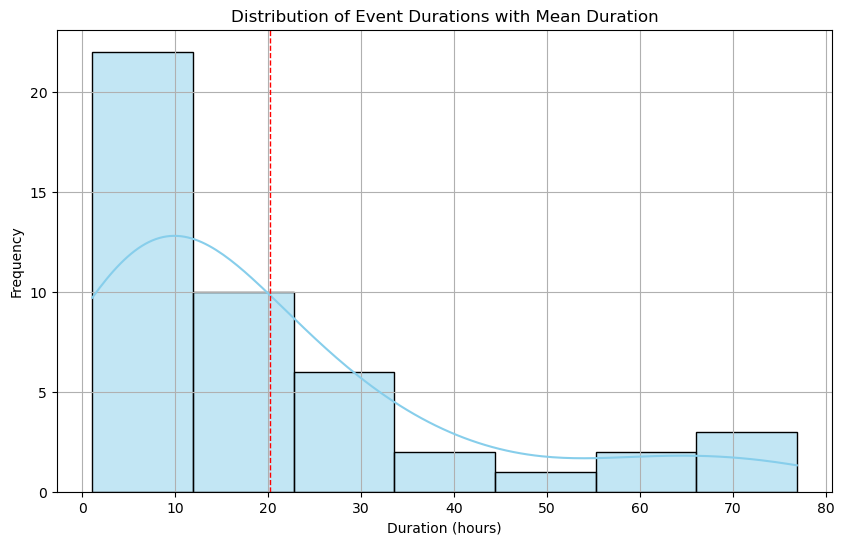

average sep duration: 0 days 20:13:56.086956521


In [2]:
avg_sep_duration = calculate_average_duration(df, start_year=2010, end_year=2017, debug=True)

# print the duration
print(f"average sep duration: {avg_sep_duration}")